In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_163.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_330.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_498.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_167.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_76.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_439.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_226.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_168.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_96.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_64.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_373.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_115.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_20.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_559.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten
import warnings
warnings.filterwarnings('ignore')


2024-04-02 17:08:07.375831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 17:08:07.375954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 17:08:07.689804: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
path = '/kaggle/input/yawn-eye-dataset-new/dataset_new'
print(os.listdir(path))

['test', 'train']


In [4]:
train_path = path + '/train'
test_path = path + '/test'

In [5]:
train_classes = os.listdir(train_path)
print(train_classes)
test_classes = os.listdir(test_path)
print(test_classes)

['Closed', 'Open', 'yawn', 'no_yawn']
['Closed', 'Open', 'yawn', 'no_yawn']


In [6]:
img_size = 224
no_channel = 3

In [7]:
X_tr = []
y_tr = []
for label in train_classes:
    data_path = os.path.join(train_path, label)
    class_num = train_classes.index(label)
    for img in os.listdir(data_path):
            try:
                img_arr = cv2.imread(os.path.join(data_path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                X_tr.append(resized_arr)
                y_tr.append(class_num)
            except Exception as e:
                print(e)

In [8]:
X_tr = np.asarray(X_tr)
X_tr = X_tr/255
y_tr = np.asarray(y_tr)
y_tr = to_categorical(y_tr)

In [9]:
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size = 0.2, random_state = 1)

In [10]:
X_test = []
y_test = []
for label in test_classes:
    data_path = os.path.join(test_path, label)
    class_num = test_classes.index(label)
    for img in os.listdir(data_path):
            try:
                img_arr = cv2.imread(os.path.join(data_path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                X_test.append(resized_arr)
                y_test.append(class_num)
            except Exception as e:
                print(e)

In [11]:
X_test = np.asarray(X_test)
X_test = X_test/255
y_test = np.asarray(y_test)
y_test = to_categorical(y_test)

In [12]:
print('X training shape :', X_tr.shape)
print('y training shape :', y_tr.shape)
print('X validation shape :', X_val.shape)
print('y validation shape :', y_val.shape)
print('X testing shape :', X_test.shape)
print('y testing shape :', y_test.shape)

X training shape : (1973, 224, 224, 3)
y training shape : (1973, 4)
X validation shape : (494, 224, 224, 3)
y validation shape : (494, 4)
X testing shape : (433, 224, 224, 3)
y testing shape : (433, 4)


In [13]:
# Load InceptionV3 model without top (fully connected) layers
model_Inceptionv3 = InceptionV3(include_top=False, input_shape=(img_size, img_size, no_channel), weights='imagenet')

# Freeze the layers in the base model
for layer in model_Inceptionv3.layers:
    layer.trainable = False

# Add custom top layers
inp=model_Inceptionv3.input
x = model_Inceptionv3.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(4, activation='softmax')(x)

# Combine the base model and custom top layers

model = Model(inputs = inp, outputs = out)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam',
              metrics = ['accuracy'])

In [15]:
hist = model.fit(X_tr,
                 y_tr,
                 epochs = 50,
                 validation_data = (X_val, y_val))

Epoch 1/50
 1/62 ━━━━━━━━━━━━━━━━━━━━ 27:12 27s/step - accuracy: 0.2188 - loss: 2.2900

I0000 00:00:1712079401.566045      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712079401.619544      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.5920 - loss: 10.5896

W0000 00:00:1712079422.242240      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712079428.960818      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 65s 631ms/step - accuracy: 0.5939 - loss: 10.5094 - val_accuracy: 0.8907 - val_loss: 0.3262
Epoch 2/50
 1/62 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.9375 - loss: 0.0951

W0000 00:00:1712079440.143434      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8593 - loss: 0.3553 - val_accuracy: 0.8664 - val_loss: 0.3222
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9092 - loss: 0.2122 - val_accuracy: 0.9028 - val_loss: 0.2190
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9534 - loss: 0.1223 - val_accuracy: 0.9170 - val_loss: 0.1936
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9756 - loss: 0.0714 - val_accuracy: 0.9291 - val_loss: 0.2264
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9727 - loss: 0.0888 - val_accuracy: 0.9190 - val_loss: 0.2107
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9739 - loss: 0.0646 - val_accuracy: 0.9109 - val_loss: 0.3604
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9834 - loss: 0.0551 - val_accuracy: 0.9150 - val_loss: 0.3889
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9833 - loss: 0.0607 - val_accuracy: 0.9595 - val_loss: 0

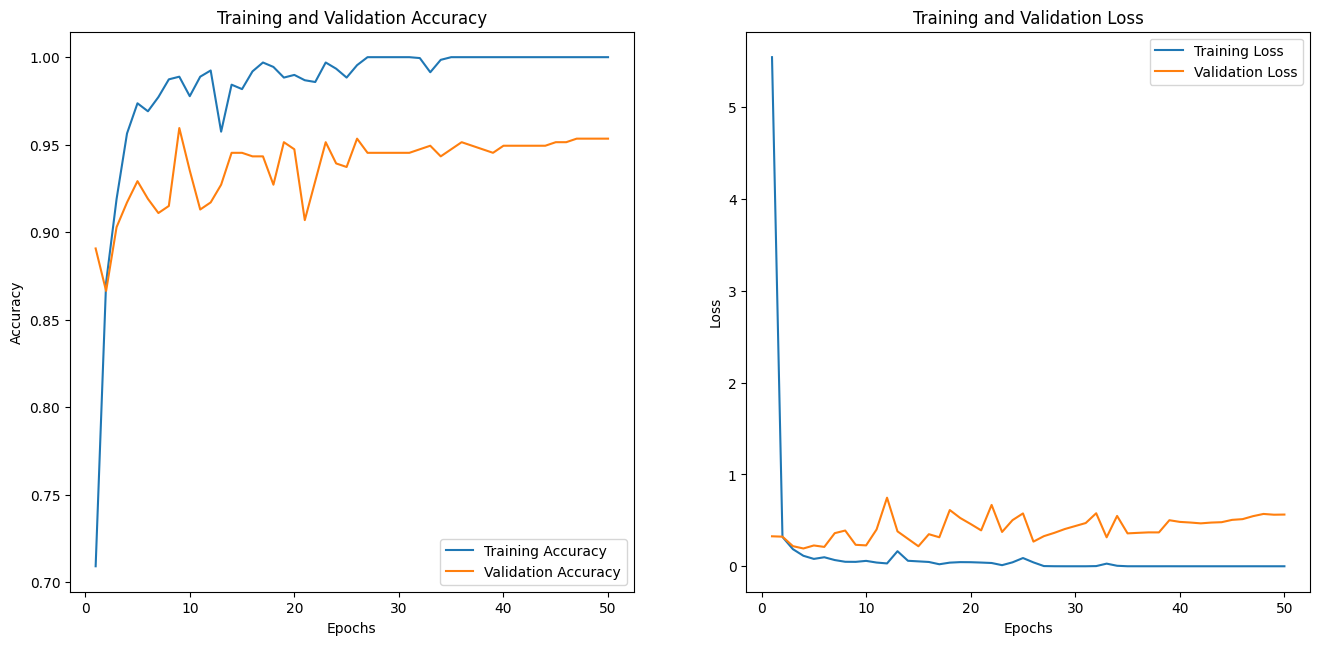

In [17]:
epochs_range = range(1, 51)

plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()


In [18]:
pred_X = model.predict(X_test)
y_pred = np.argmax(pred_X, axis = 1)
y_test = np.argmax(y_test, axis = 1)

 3/14 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

W0000 00:00:1712080303.134241      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


W0000 00:00:1712080317.239027      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Text(0.5, 1.0, 'CNN Confusion Matrix')

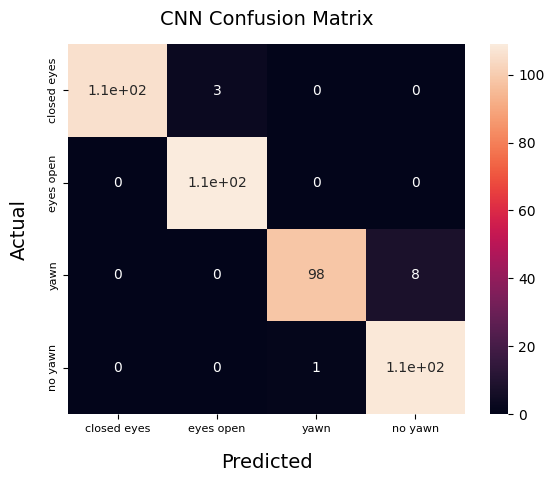

In [19]:
cm = confusion_matrix(y_test, y_pred)
hm = sns.heatmap(cm, annot = True)
hm.set_xlabel("Predicted", fontsize = 14, labelpad = 14)
hm.xaxis.set_ticklabels(['closed eyes', 'eyes open', 'yawn', 'no yawn'], fontsize = 8)
hm.set_ylabel("Actual", fontsize = 14, labelpad = 14)
hm.yaxis.set_ticklabels(['closed eyes', 'eyes open', 'yawn', 'no yawn'], fontsize = 8)
hm.set_title("CNN Confusion Matrix", fontsize = 14, pad = 14)

In [20]:
print(classification_report(y_test, y_pred, target_names = ['closed eyes', 'eyes open', 'yawn', 'no yawn']))

              precision    recall  f1-score   support

 closed eyes       1.00      0.97      0.99       109
   eyes open       0.97      1.00      0.99       109
        yawn       0.99      0.92      0.96       106
     no yawn       0.93      0.99      0.96       109

    accuracy                           0.97       433
   macro avg       0.97      0.97      0.97       433
weighted avg       0.97      0.97      0.97       433



In [23]:
import cv2
import numpy as np

def preprocess_image(image_path, img_size):
    img = cv2.imread(image_path)[...,::-1] # Read and convert to RGB
    resized_img = cv2.resize(img, (img_size, img_size)) # Resize image to match model input size
    preprocessed_img = resized_img / 255.0 # Normalize pixel values
    return np.expand_dims(preprocessed_img, axis=0) # Add batch dimension

def predict_image(model, image_path, img_size):
    preprocessed_img = preprocess_image(image_path, img_size)
    prediction = model.predict(preprocessed_img)
    class_index = np.argmax(prediction)
    return class_index, prediction[0][class_index]

# Example usage:
image_path = '/kaggle/input/yawnerr/yawner.jpg' # Path to the new input image
class_index, confidence = predict_image(model, image_path, img_size)

# Get the class label corresponding to the predicted index
class_label = train_classes[class_index]

print("Predicted Class:", class_label)
print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Class: yawn
Confidence: 1.0


In [24]:
model.save('inceptionv3_pretrained.h5')